In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset, is_uniform, infer_freq
from gluonts.dataset.split import split, TestData
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.eval_util.evaluation import evaluate_model
from gluonts.ev.metrics import MAE, MAPE

from mov_av import moving_average

In [2]:
it_data_23_24 = pd.read_csv('data/it_load_data_23_24.csv', delimiter=',')
it_data_23_24['DateUTC'] = pd.to_datetime(it_data_23_24['DateUTC'])
it_data_23_24 = it_data_23_24.set_index('DateUTC')

In [4]:
from uni2ts.alex.common.benchmark_func import *

In [48]:
def get_metrics_v2(model_folder: str):
    metrics = {"mean": [], "median": [], "lower_0025": [], "upper_0975": []}
    for i in range(1, 31):
        model, test_data = get_model_data(
                                model_folder=model_folder,
                                prediction_lenght=168,
                                num_of_weeks=i,
                                data=data,
                                patch_size="auto",
                                num_samples=500,
                            )
        
        forecast_samples, target_values = get_eval_foreasts(model, test_data)

        mean_error_ts = (np.mean(forecast_samples, axis=1).flatten() - target_values.flatten())/target_values.flatten()
        mean_error_ts = np.abs(mean_error_ts)
    
        median_error_ts = (np.quantile(forecast_samples, 0.5, axis=1).flatten() - target_values.flatten())/target_values.flatten()
        median_error_ts = np.abs(median_error_ts)
        
        upper_error_ts = (np.quantile(forecast_samples, 0.975, axis=1).flatten() - target_values.flatten())/target_values.flatten()
        upper_error_ts = np.abs(upper_error_ts)
        
        lower_error_ts = (np.quantile(forecast_samples, 0.025, axis=1).flatten() - target_values.flatten())/target_values.flatten()
        lower_error_ts = np.abs(lower_error_ts)

        metrics['mean'].append(np.mean(median_error_ts))
        metrics['median'].append(np.mean(median_error_ts))
        metrics['lower_0025'].append(np.mean(lower_error_ts))
        metrics['upper_0975'].append(np.mean(upper_error_ts))

    return metrics

In [49]:
# # plt.figure(figsize=(8, 8))
# plt.plot(
#     range(1, 31),
#     np.array(metrics['mean']),
#     label="mean",
# )

# plt.fill_between(
#     range(1, 31),
#     np.array(metrics['lower_025']),
#     np.array(metrics['upper_0975']),
#     alpha=0.5,
#     label="a=0.05",
# )
# plt.legend();

In [50]:
data = it_data_23_24

model_folder = "outputs/finetune/moirai_small/1st_run/checkpoints/it_load_data_train_"
# backtesting_with_refit = get_metrics(model_folder, prediction_lenght=7*24,
#                                      data=data, metric="MAPE", quantiles=[0.05, 0.5, 0.95], num_samples=200)
backtesting_with_refit = get_metrics_v2(model_folder)

# model_folder = "outputs/finetune/moirai_small/2nd_run/checkpoints/it_load_data_train_"
# refit_1_pass =  get_run_metrics(model_folder, data, "MAPE")

# model_folder = "outputs/finetune/moirai_small/3rd_run/checkpoints/it_load_data_train_"
# refit_multiple_passes = get_run_metrics(model_folder, data, "MAPE")

model_folder = "pretrained"
# pretrained = get_metrics(model_folder, prediction_lenght=7*24,
#                          data=data, metric="MAPE", quantiles=[0.05, 0.5, 0.95], num_samples=200)
pretrained = get_metrics_v2(model_folder)

In [51]:
# backtesting_with_refit = pd.concat(backtesting_with_refit, axis=0)
# refit_1_pass = pd.concat(refit_1_pass, axis=0)
# refit_multiple_passes = pd.concat(refit_multiple_passes, axis=0)
# pretrained = pd.concat(pretrained, axis=0)

backtesting_with_refit = pd.DataFrame.from_dict(backtesting_with_refit)
pretrained = pd.DataFrame.from_dict(pretrained)

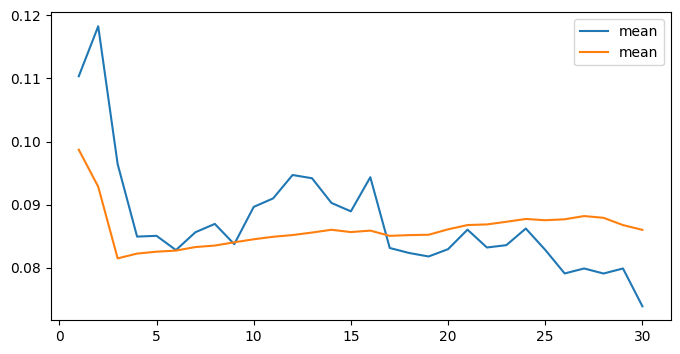

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, 31),
    backtesting_with_refit['mean'],
    label="mean",
)

# plt.fill_between(
#     range(1, 31),
#     backtesting_with_refit['median']-backtesting_with_refit['lower_0025'],
#     backtesting_with_refit['median']+backtesting_with_refit['upper_0975'],
#     alpha=0.5,
#     label="a=0.05",
# )

plt.plot(
    range(1, 31),
    pretrained['mean'],
    label="mean",
)

# plt.fill_between(
#     range(1, 31),
#     pretrained['lower_0025'],
#     pretrained['upper_0975'],
#     alpha=0.5,
#     label="a=0.05",
# )
plt.legend();

In [57]:
plt.figure(figsize=(8, 8))
backtesting_with_refit['MAPE[0.5]'].plot(label='Backtesting with refit')
# refit_1_pass['MAPE[0.95]'].plot(label='Refit (1 backword pass)')
# refit_multiple_passes['MAPE[0.95]'].plot(label='Refit (multiple backword passes)')
pretrained['MAPE[0.5]'].plot(label='Pretrained')
plt.xticks(range(0, 30), range(1, 31))
plt.xlabel('Number of weeks')
plt.ylabel('MAPE')
plt.title('Benchmark on MAPE based on X-th percentile')
plt.legend()
plt.tight_layout()
# plt.savefig("experiment_results/after_finetuning/mape_95th_perc.png");

In [ ]:
backtesting_with_refit['MAPE[0.5]'].plot(label='Backtesting with refit')
refit_1_pass['MAPE[0.5]'].plot(label='Refit (1 backword pass)')
refit_multiple_passes['MAPE[0.5]'].plot(label='Refit (multiple backword passes)')
pretrained['MAPE[0.5]'].plot(label='Pretrained')
plt.xticks(range(0, 26), range(1, 27))
plt.xlabel('Number of weeks')
plt.ylabel('MAPE')
plt.title('Benchmark on MAPE based on 50th percentile')
plt.legend()
plt.tight_layout()
plt.savefig("experiment_results/after_finetuning/mape_50th_perc.png");

In [ ]:
model_folder = "outputs/finetune/moirai_small/1st_run/checkpoints/it_load_data_train_"
data = it_data_23_24

model, test_data = get_model_data(model_folder, 26, data)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

NUM_WINDOWS = 1

fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, NUM_WINDOWS * 4))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=1 * 168,
    intervals=(0.9, 0.95),
    dim=None,
    name="Prediction",
    show_label=True,
)
plt.tight_layout()

In [ ]:
model = load_pretrained(720)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

NUM_WINDOWS = 1

fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, NUM_WINDOWS * 4))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=1 * 168,
    intervals=(0.9, 0.95),
    dim=None,
    name="Prediction",
    show_label=True,
)
plt.tight_layout()